# Power comparison under different hypotheses

In hypothesis testing, we can test different hypotheses. The most common are:
- Two-sided: the effect is different from zero (commonly noted as H0: beta = 0, H1: beta != 0)
- Less: the effect is less than zero (H0: beta >= 0, H1: beta < 0)
- Greater: the effect is greater than zero (H0: beta <= 0, H1: beta > 0)

In the example below, we show how different hypotheses affect the power of the test. We use the same data as in a previous example.

In [10]:
from datetime import date
import numpy as np
import pandas as pd
from cluster_experiments import PowerAnalysis
import matplotlib.pyplot as plt
np.random.seed(42)


# Create fake data
N = 1000
clusters = [f"Cluster {i}" for i in range(50)]
dates = [f"{date(2022, 1, i):%Y-%m-%d}" for i in range(1, 32)]
df = pd.DataFrame(
    {
        "cluster": np.random.choice(clusters, size=N),
        "target": np.random.normal(0, 1, size=N),
        "date": np.random.choice(dates, size=N),
    }
)



In [17]:
results = []

for hypothesis in ["two-sided", "less", "greater"]:
        for analysis in ["ols_clustered", "gee"]:
                config = {
                    "analysis": analysis,
                    "perturbator": "constant",
                    "splitter": "clustered",
                    "n_simulations": 50,
                    "hypothesis": hypothesis,
                    "cluster_cols": ['cluster', 'date'],
                }
                pw = PowerAnalysis.from_dict(config)
                # power = pw.power_analysis(df, average_effect=0.1)

                power_dict = pw.power_line(df, average_effects=[0, 0.01, 0.02, 0.03, 0.5])
                power_df = pd.DataFrame(list(power_dict.items()), columns=['average_effect', 'power'])

                power_df['hypothesis'] = hypothesis
                power_df['analysis'] = analysis

                results.append(power_df)


final_df = pd.concat(results, ignore_index=True)



In [18]:
final_df

,average_effect,power,hypothesis,analysis
0,0.00,0.04,two-sided,ols_clustered
1,0.01,0.04,two-sided,ols_clustered
2,0.02,0.14,two-sided,ols_clustered
3,0.03,0.02,two-sided,ols_clustered
4,0.50,1.00,two-sided,ols_clustered
5,0.00,0.12,two-sided,gee
6,0.01,0.04,two-sided,gee
7,0.02,0.06,two-sided,gee
8,0.03,0.02,two-sided,gee
9,0.50,1.00,two-sided,gee


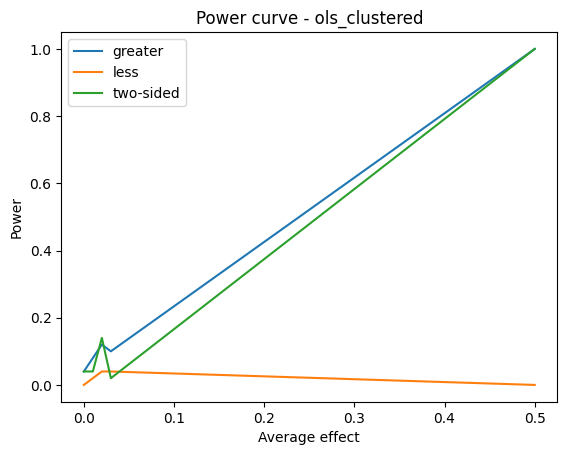

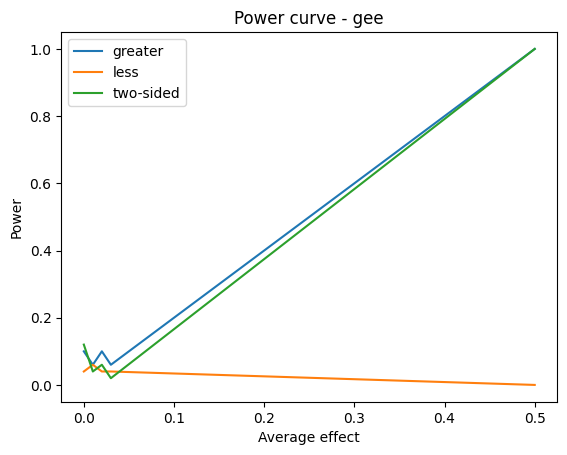

In [19]:
# df = pd.DataFrame(results.items(), columns=["average_effect", "power"])

# plot using matplotlib
for analysis in ['ols_clustered', 'gee']:
    fig, ax = plt.subplots()
    for category, group in final_df.query("analysis == @analysis").groupby('hypothesis'):
        ax.plot(group['average_effect'], group['power'], label=category)
    #ax.plot(final_df["average_effect"],final_df["power"], label= final_df["hypothesis"])
    ax.set_xlabel("Average effect")
    ax.set_ylabel("Power")
    ax.set_title(f"Power curve - {analysis}")
    ax.legend()
    plt.show()